In [7]:
import pandas as pd
from datetime import datetime,timedelta
import numpy as np
import teradata
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open("clt","rb") as pickle_in:
    df=pickle.load(pickle_in)

In [3]:
df.head()

,Date (YYYY-MM-DD),Time in UTC (hh:mm:ss),Latitude,Longitude,Polarity (Positive or Negative) and Peak Current (kiloamps),Lightning type (C=Cloud ; G=Cloud-to-Ground),Radial distance from airport centerpoint (miles),time
0,2013-10-07,1900-01-01 10:55:22,35.3381,-81.2541,+3.6,C,19.53,2013-10-07 10:55:00
1,2013-10-07,1900-01-01 10:55:23,35.4153,-81.1741,+5.5,C,19.06,2013-10-07 10:55:00
2,2013-10-07,1900-01-01 10:56:51,35.3861,-81.2228,+5.6,C,19.76,2013-10-07 10:56:00
3,2013-10-07,1900-01-01 10:56:51,35.3818,-81.2253,+3.5,C,19.69,2013-10-07 10:56:00
4,2013-10-07,1900-01-01 10:58:44,35.3855,-81.2283,+5.3,C,19.98,2013-10-07 10:58:00


In [4]:
df['Radial distance from airport centerpoint (miles)']=pd.to_numeric(df['Radial distance from airport centerpoint (miles)'])
df=df.sort_values(by=['time'])
def calc(df,radius,types):
    df_new=df.loc[(df['Radial distance from airport centerpoint (miles)']<=radius)]
    df_new['filter']=df_new['Lightning type (C=Cloud ; G=Cloud-to-Ground)'].apply(lambda x:'y' if x in types else 'n')
    df_new=df_new.loc[df_new['filter']=='y']
    start=start_new=df_new['time'].iloc[0]
    df_new=df_new.append({'time':start+timedelta(days=100)},ignore_index=True)
    result=pd.DataFrame()
    for index,row in df_new.iterrows():
        if row['time']-start_new>timedelta(minutes=10):
            end=start_new+timedelta(minutes=10)
            result=result.append({'start':start,'end':end},ignore_index=True)
            start_new=row['time']
            start=row['time']
        else:
            start_new=row['time']
    result=result[['start','end']]
    result['length']=(result['end']-result['start'])/timedelta(minutes=1)
    result['year']=result['start'].apply(lambda x:x.year)
    result['month']=result['start'].apply(lambda x:x.month)
    result['hour']=result['start'].apply(lambda x:x.hour)
    return(result)

In [11]:
result=calc(df,3,['G'])
result['type']='3G'
result2=calc(df,5,['G','C'])
result2['type']='5Gc'
result_all=result.append(result2)

In [13]:
result_all.head()

,start,end,length,year,month,hour,type
0,2014-01-11 11:52:00,2014-01-11 12:17:00,25.0,2014,1,11,3G
1,2014-02-19 07:16:00,2014-02-19 08:25:00,69.0,2014,2,7,3G
2,2014-02-19 08:28:00,2014-02-19 08:49:00,21.0,2014,2,8,3G
3,2014-04-30 07:07:00,2014-04-30 07:17:00,10.0,2014,4,7,3G
4,2014-04-30 07:22:00,2014-04-30 07:32:00,10.0,2014,4,7,3G


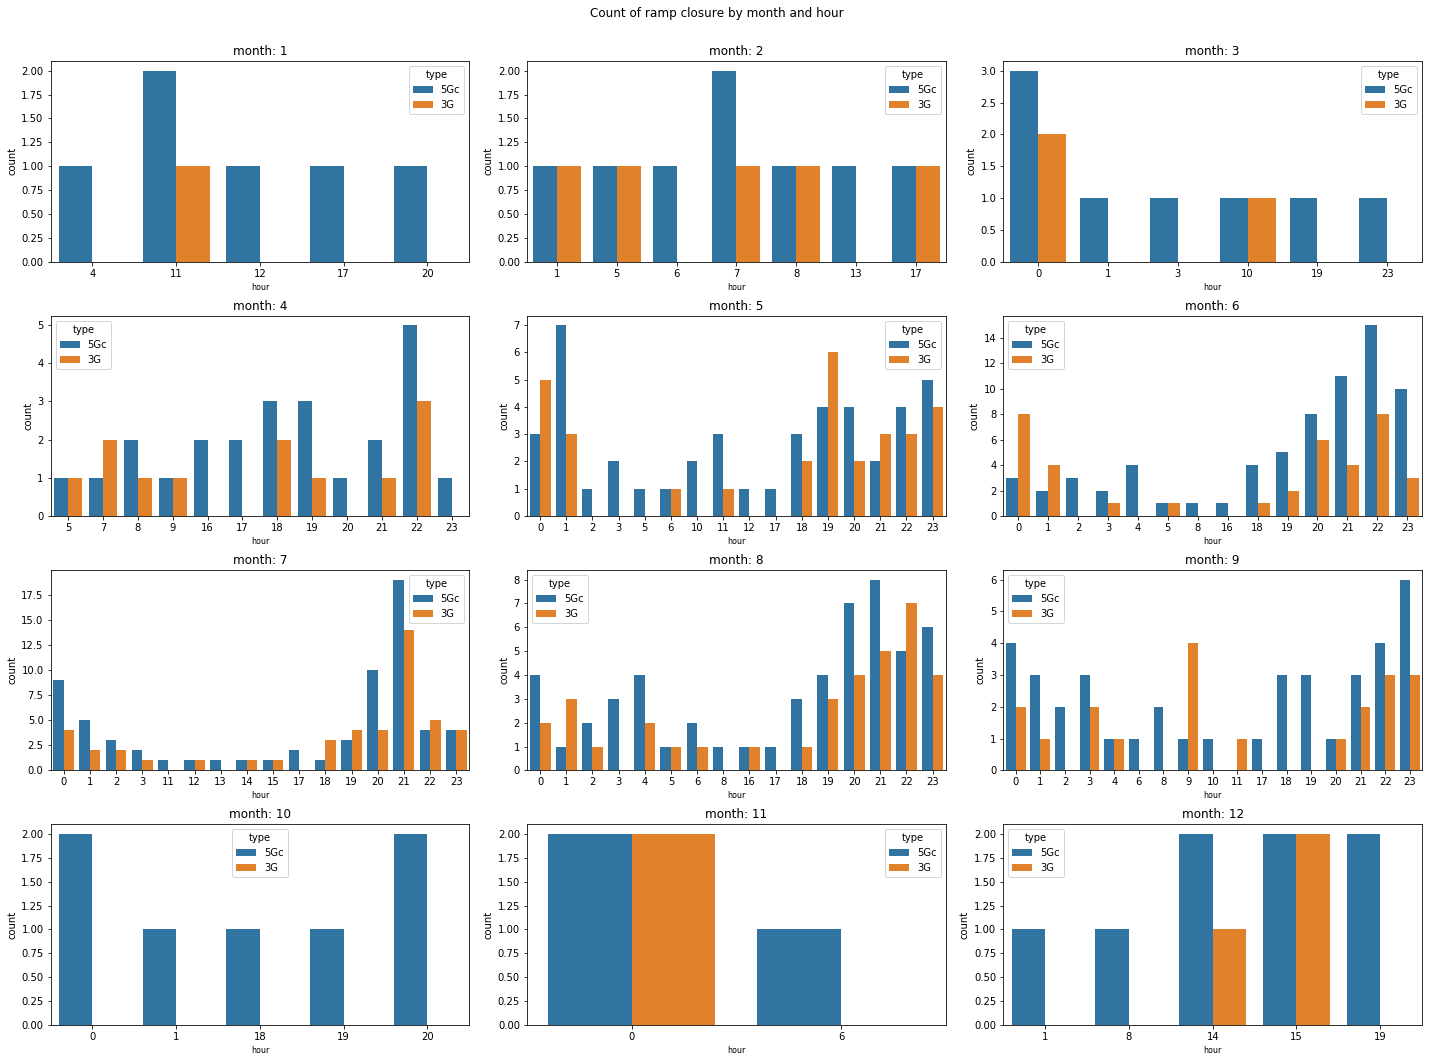

In [50]:
fig = plt.figure(figsize=(20, 15))

for i in range(1,13):
    ax=fig.add_subplot(4,3,i)
    sns.countplot(x='hour',data=result_all.loc[result_all['month']==i],hue='type',hue_order=['5Gc','3G'])
    plt.title("month: %i" %i,fontsize=12)
    plt.xlabel('hour', fontsize=8)
    plt.tight_layout()
fig.suptitle("Count of ramp closure by month and hour")
fig.subplots_adjust(top=0.93)
plt.savefig('count.png')

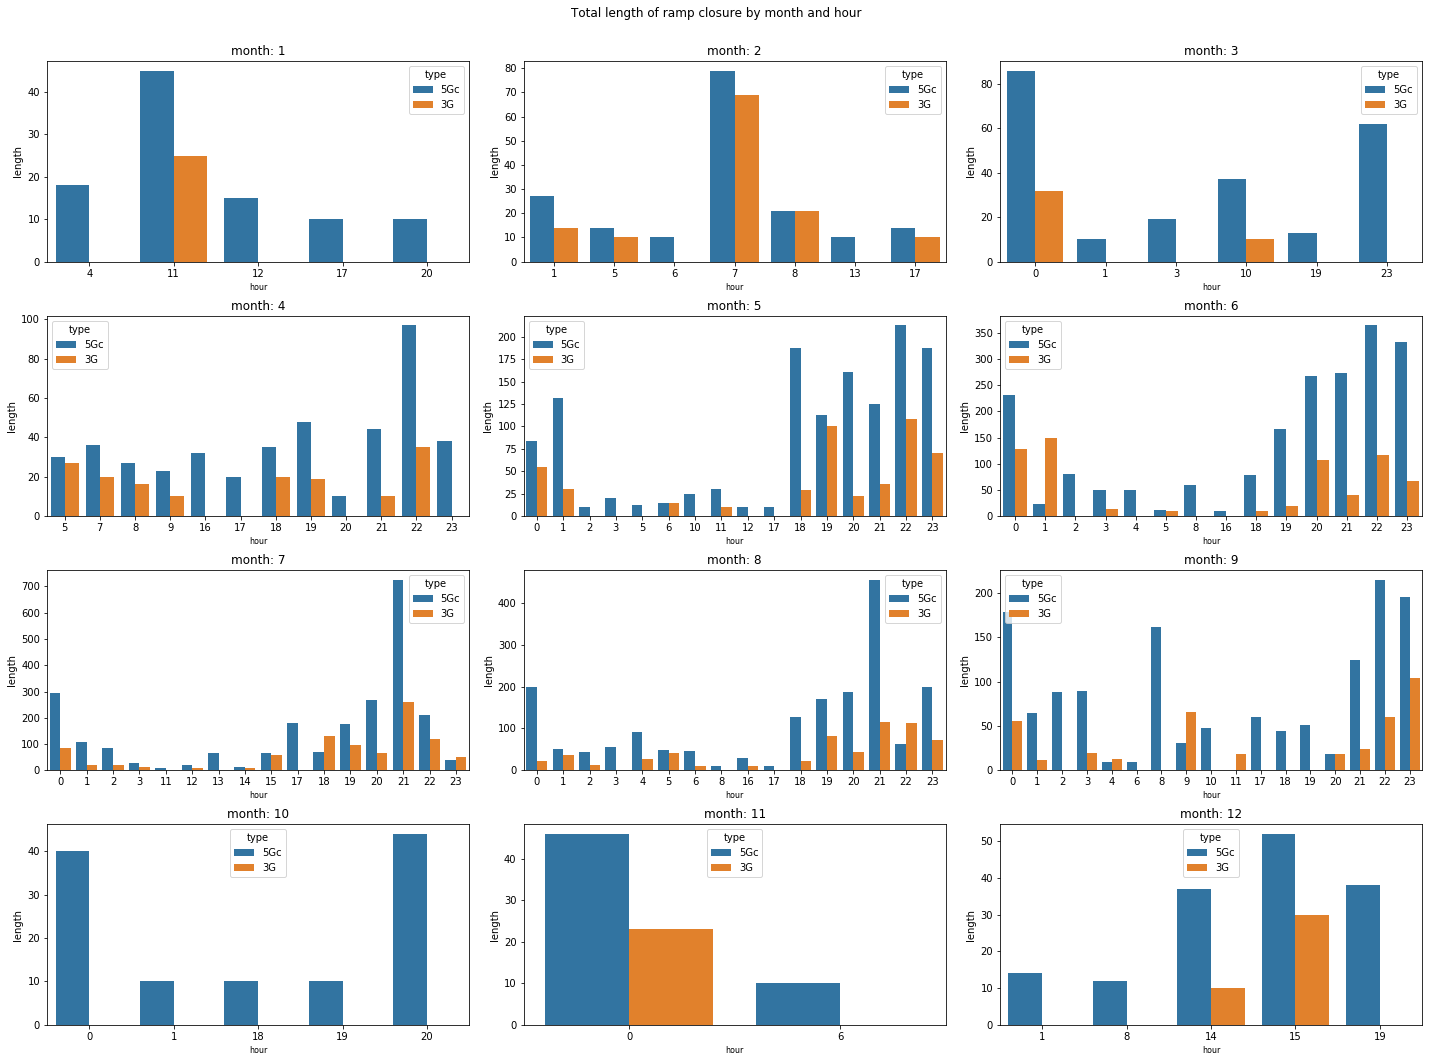

In [52]:
fig = plt.figure(figsize=(20, 15))

for i in range(1,13):
    ax=fig.add_subplot(4,3,i)
    sns.barplot(x='hour',y='length',data=result_all.loc[result_all['month']==i],hue='type',hue_order=['5Gc','3G'],ci=None,estimator=sum)
    plt.title("month: %i" %i,fontsize=12)
    plt.xlabel('hour', fontsize=8)
    plt.tight_layout()
fig.suptitle("Total length of ramp closure by month and hour")
fig.subplots_adjust(top=0.93)
plt.savefig("length.png")

In [10]:
end='2018-12-13'

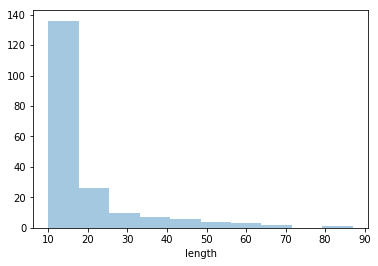

In [55]:
sns.distplot(result['length'],bins=10,kde=False)